In [1]:
import sys
import os
import glob
import shutil
import numpy as np
import cv2
import lmdb
import random

from matplotlib import pyplot as plt
from skimage import exposure
%matplotlib inline

In [2]:
sys.path.insert(0, '/home/nathan/caffe-segnet-crf/python')
import caffe
from caffe.proto import caffe_pb2

# Random crops

In [88]:
def refine(img, kernel):
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

In [95]:
# Prostate Cancer images
# image_source = '/home/nathan/histo-seg/semantic-pca/data/source_training/jpg'
# mask_source = '/home/nathan/histo-seg/semantic-pca/data/source_training/mask'

# ccRCC images
image_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_jpg'
mask_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_png'

'''
For rearranging the mask labels:
{original: new, original: new, etc.}
'''
# rearr = {3:0, 0:1, 1:1, 2:1, 4:1}
# rearr = {29:0, 79:1, 94:2, 190:3, 255:3}
rearr = {29:0, 79:1, 94:2}
backgroundkey = 3

img_list = sorted(glob.glob(
    os.path.join(image_source, '*.jpg')
))
mask_list = sorted(glob.glob(
    os.path.join(mask_source, '*.png')
))

# Shuffle:
c = list(zip(img_list, mask_list))
random.shuffle(c)
img_list, mask_list = zip(*c)

print 'Found {} images in {}'.format(len(img_list), image_source)
print 'Found {} images in {}'.format(len(mask_list), mask_source)


# h,w = sampleimg.shape[:2]
# print h,w

winsize = 512
scale = 2
winwrite = winsize / scale
n = 25
border = 200

hlist = [cv2.imread(il).shape[0] for il in img_list]
r = lambda h: np.random.randint(h-winsize-border)+border
coords = [[(r(h), r(h)) for _ in range(n)] for h in hlist]


'''
Create an lmdb database of images

'''
# image_db = '/home/nathan/histo-seg/semantic-pca/data/db/feature_lmdb'
# mask_db = '/home/nathan/histo-seg/semantic-pca/data/db/mask_lmdb'
# mask_imgs = '/home/nathan/histo-seg/semantic-pca/data/debug_mask'
# debug_dir = '/home/nathan/histo-seg/semantic-pca/data/debug'

image_db = '/home/nathan/histo-seg/semantic-ccrcc/data/db/feature_lmdb'
mask_db = '/home/nathan/histo-seg/semantic-ccrcc/data/db/mask_lmdb'
mask_imgs = '/home/nathan/histo-seg/semantic-ccrcc/data/debug_mask'
debug_dir = '/home/nathan/histo-seg/semantic-ccrcc/data/debug'

# This block of logic so I don't have to keep redoing it.
if os.path.exists(image_db): print('Remaking {}'.format(image_db)); shutil.rmtree(image_db)
if os.path.exists(mask_db): print('Remaking {}'.format(mask_db));shutil.rmtree(mask_db)
if os.path.exists(debug_dir): print('Remaking {}'.format(debug_dir)); shutil.rmtree(debug_dir); os.mkdir(debug_dir)
if os.path.exists(mask_imgs): print('Remaking {}'.format(mask_imgs)); shutil.rmtree(mask_imgs); os.mkdir(mask_imgs)

if not os.path.exists(debug_dir): print('Making {}'.format(debug_dir)); os.mkdir(debug_dir)
if not os.path.exists(mask_imgs): print('Making {}'.format(mask_imgs)); os.mkdir(mask_imgs)

# Since we're cropping this is always going to be super adequate
safety = 5
sampleimg = cv2.imread(img_list[0])
est_total = sampleimg.nbytes * len(img_list) * n  # Number of crops instead.


'''
Write feature images (3-channel)
'''
env = lmdb.open(image_db, map_size=est_total)
index = 1
with env.begin(write=True) as txn:
    for k, (img_name, crops) in enumerate(zip(img_list, coords)):
        img = cv2.imread(img_name)
        
        for box in crops:
            x = box[0]
            y = box[1]
            subimg_ = img[x:x+winsize, y:y+winsize, :]
            subimg_ = cv2.resize(subimg_, dsize=(winwrite, winwrite))
            
            # From BVLC/caffe/issues/1698
            subimg = subimg_[:,:,::-1]
            subimg = subimg.transpose((2,0,1))
            
            datum = caffe.io.array_to_datum(subimg)
            str_id = '{:07}'.format(index)
            
            txn.put(str_id.encode('ascii'), datum.SerializeToString())
            if index % n == 0:
                print str_id
                cv2.imwrite(os.path.join(debug_dir, '{}t.png'.format(str_id)), 
                            subimg_)
            index += 1
            
print 'added {} files to {}'.format(index, image_db)
env.close()


'''
Write labels (1-channel)
'''
env = lmdb.open(mask_db, map_size=est_total)
index = 1
refinefns = {
    29: lambda img: cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))),
    79: lambda img: cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))),
    94: lambda img: cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
}

with env.begin(write=True) as txn:
    for k, (img_name, crops) in enumerate(zip(mask_list, coords)):
        img = cv2.imread(img_name, 0)
        
        '''
        Replace labels according to rearr dict
        '''
#         img_copy = np.copy(img)
        img_copy = np.zeros_like(img, dtype=np.uint8) + backgroundkey
        for key in rearr.iterkeys():
            img_hold = img == key
            img_hold.dtype = np.uint8
            img_hold = refinefns[key](img_hold)
            img_hold.dtype = np.bool
            img_copy[img_hold] = rearr[key]
        
        img = img_copy
        
        for box in crops:
            x = box[0]
            y = box[1]
            subimg_ = img[x:x+winsize, y:y+winsize]
            subimg_ = cv2.resize(subimg_, dsize=(winwrite, winwrite),
                                interpolation=cv2.INTER_NEAREST)
            subimg = np.expand_dims(subimg_, 0)  # (1, h, w)
            
            datum = caffe.io.array_to_datum(subimg)
            str_id = '{:07}'.format(index)
            
            txn.put(str_id.encode('ascii'), datum.SerializeToString())
            
            ### Only do this for test, or for small n
            cv2.imwrite(os.path.join(mask_imgs, '{}.png'.format(str_id)), subimg_)
            ###
            
            
            if index % n == 0:
                print str_id
#                 print 'subimg max: {}'.format(subimg_.max())
                cv2.imwrite(os.path.join(debug_dir, '{}t_.png'.format(str_id)), 
                            subimg_*(255/subimg_.max()))
            index += 1
            
print 'added {} files to {}'.format(index, mask_db)
env.close()
print 'done'

Found 130 images in /home/nathan/histo-seg/semantic-ccrcc/data/source_jpg
Found 130 images in /home/nathan/histo-seg/semantic-ccrcc/data/source_png
Remaking /home/nathan/histo-seg/semantic-ccrcc/data/db/feature_lmdb
Remaking /home/nathan/histo-seg/semantic-ccrcc/data/db/mask_lmdb
Remaking /home/nathan/histo-seg/semantic-ccrcc/data/debug
Remaking /home/nathan/histo-seg/semantic-ccrcc/data/debug_mask
0000025
0000050
0000075
0000100
0000125
0000150
0000175
0000200
0000225
0000250
0000275
0000300
0000325
0000350
0000375
0000400
0000425
0000450
0000475
0000500
0000525
0000550
0000575
0000600
0000625
0000650
0000675
0000700
0000725
0000750
0000775
0000800
0000825
0000850
0000875
0000900
0000925
0000950
0000975
0001000
0001025
0001050
0001075
0001100
0001125
0001150
0001175
0001200
0001225
0001250
0001275
0001300
0001325
0001350
0001375
0001400
0001425
0001450
0001475
0001500
0001525
0001550
0001575
0001600
0001625
0001650
0001675
0001700
0001725
0001750
0001775
0001800
0001825
0001850
000187

# Check range and data type for images and masks

Found 130 images in /home/nathan/histo-seg/semantic-ccrcc/data/source_img
Found 130 images in /home/nathan/histo-seg/semantic-ccrcc/data/source_mask
Img /home/nathan/histo-seg/semantic-ccrcc/data/source_img/08_1_reg22.tif
Mask /home/nathan/histo-seg/semantic-ccrcc/data/source_mask/08_1_reg22.tif
Image dtpe:  uint8
Unique labels:  [0 1 2 3]
Label dtype:  uint8


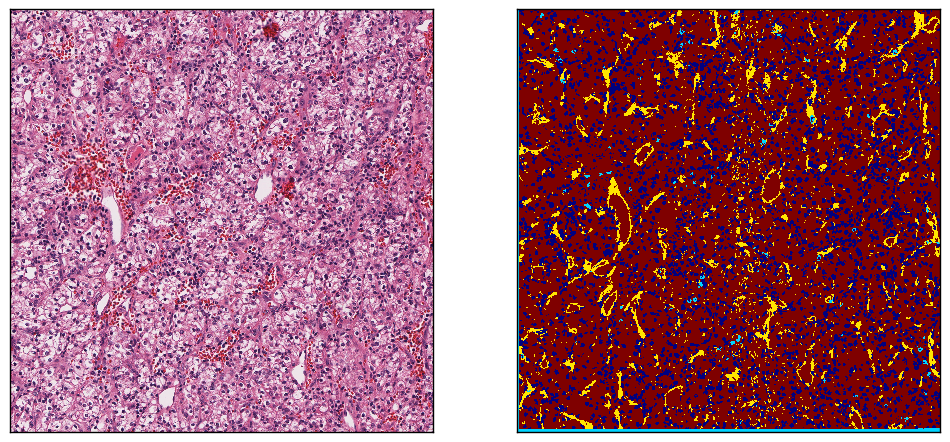

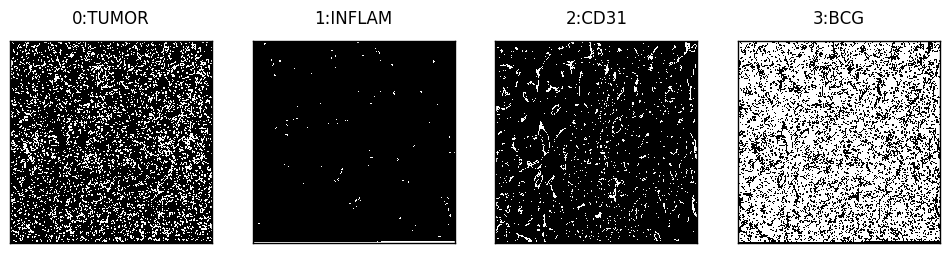

In [92]:
# Prostate Cancer images
# image_source = '/home/nathan/histo-seg/semantic-pca/data/source_training/jpg'
# mask_source = '/home/nathan/histo-seg/semantic-pca/data/source_training/mask'

# ccRCC images
image_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_img'
mask_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_mask'

# rearr = {3:0, 0:1, 1:1, 2:1, 4:1}
rearr = {29:0, 79:1, 94:2, 190:3, 255:3}
# rearr_str = {29:'tumor', 79:'inflam', 94:'cd31', 190:'bcg', 255:'bcg'}
rearr_str = {0:'TUMOR', 1:'INFLAM', 2:'CD31', 3:'BCG'}
refinefns = {
    0: lambda img: cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))),
    1: lambda img: cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))),
    2: lambda img: cv2.morphologyEx(img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))),
    3: lambda img: cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
}

img_list = sorted(glob.glob(
    os.path.join(image_source, '*.tif')
))
mask_list = sorted(glob.glob(
    os.path.join(mask_source, '*.tif')
))

c = list(zip(img_list, mask_list))
random.shuffle(c)
img_list, mask_list = zip(*c)


print 'Found {} images in {}'.format(len(img_list), image_source)
print 'Found {} images in {}'.format(len(mask_list), mask_source)

index = np.random.randint(len(mask_list))
print 'Img {}\nMask {}'.format(img_list[index], mask_list[index])
sampleimg = cv2.imread(img_list[index])
sampleimg = sampleimg[:,:,::-1]
samplemask = cv2.imread(mask_list[index], 0)

samplemask_copy = np.copy(samplemask)
for key in rearr.iterkeys():
    samplemask_copy[samplemask ==  key] = rearr[key]
samplemask = samplemask_copy

print 'Image dtpe: ',sampleimg.dtype
print 'Unique labels: ', np.unique(samplemask)
print 'Label dtype: ', samplemask.dtype

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(sampleimg);
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].matshow(samplemask);
ax[1].set_xticks([]); ax[1].set_yticks([])

fig, ax = plt.subplots(1, len(np.unique(samplemask)), figsize=(12,4))
for a, u in zip(ax, np.unique(samplemask)):
    maskshow = samplemask==u
    maskshow.dtype = np.uint8
    maskshow = refinefns[u](maskshow)
    a.matshow(maskshow, cmap='gray')
    a.set_xticks([]); a.set_yticks([])
    a.set_title('{}:{}'.format(u, rearr_str[u]))
    

## If necessary do copy first

In [123]:
src = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1'
feature = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1_original'

feature_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_feature_test'
outline_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_outline_test'
mask_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_mask_test'
label_dest = '/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_label_test'

src_list = sorted(glob.glob(
    os.path.join(src, '*.png')
))

feature_list = sorted(glob.glob(
    os.path.join(feature, '*.tif')
))

outline_list = [img for img in src_list if 'tif.png' in img]
mask_list = [img for img in src_list if '_mask' in img]
label_list = [img for img in src_list if 'Lmask' in img]

print feature_list[0]
print img_list[0]
print mask_list[0]
print label_list[0]

rep = lambda x: os.path.join(feature_dest, os.path.basename(x))
_ = [shutil.copyfile(img, rep(img)) for img in feature_list]
print 'Done copying originals'

rep = lambda x: os.path.join(outline_dest, os.path.basename(x.replace('.tif', '')))
_ = [shutil.copyfile(img, rep(img)) for img in img_list]
print 'Done copying outlines'

rep = lambda x: os.path.join(mask_dest, os.path.basename(x.replace('.tif_mask', '')))
_ = [shutil.copyfile(img, rep(img)) for img in mask_list]
print 'Done copying masks'

rep = lambda x: os.path.join(label_dest, os.path.basename(x.replace('.tif_Lmask', '')))
_ = [shutil.copyfile(img, rep(img)) for img in label_list]
print 'Done copying labels'

/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1_original/SP 02-4466 L3_001(5+5)_1_2.tif
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/_feature/SP 04-1514 1 L3_001(3+4)_2_4.tif
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1/SP 02-4466 L3_001(5+5)_1_2.tif_mask.png
/home/nathan/mzmo/data/nuclei/nuclei_seg_0.1/M1ADT_1/SP 02-4466 L3_001(5+5)_1_2.tif_Lmask.png
Done copying originals
Done copying outlines
Done copying masks
Done copying labels


In [45]:
help(caffe.io)

Help on module caffe.io in caffe:

NAME
    caffe.io

FILE
    /home/nathan/caffe-segnet-crf/python/caffe/io.py

CLASSES
    Transformer
    
    class Transformer
     |  Transform input for feeding into a Net.
     |  
     |  Note: this is mostly for illustrative purposes and it is likely better
     |  to define your own input preprocessing routine for your needs.
     |  
     |  Parameters
     |  ----------
     |  net : a Net for which the input should be prepared
     |  
     |  Methods defined here:
     |  
     |  __init__(self, inputs)
     |  
     |  deprocess(self, in_, data)
     |      Invert Caffe formatting; see preprocess().
     |  
     |  preprocess(self, in_, data)
     |      Format input for Caffe:
     |      - convert to single
     |      - resize to input dimensions (preserving number of channels)
     |      - transpose dimensions to K x H x W
     |      - reorder channels (for instance color to BGR)
     |      - scale raw input (e.g. from [0, 1] to [

In [85]:
image_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_img'
mask_source = '/home/nathan/histo-seg/semantic-ccrcc/data/source_mask'

image_target = '/home/nathan/histo-seg/semantic-ccrcc/data/source_jpg'
mask_target = '/home/nathan/histo-seg/semantic-ccrcc/data/source_png'

img_list = sorted(glob.glob(
    os.path.join(image_source, '*.tif')
))
mask_list = sorted(glob.glob(
    os.path.join(mask_source, '*.tif')
))

for k in img_list:
    img_dest = k.replace(image_source, image_target).replace('tif', 'jpg')
    x = cv2.imread(k)
    cv2.imwrite(img_dest, x)
    print img_dest

    
for k in mask_list:
    img_dest = k.replace(mask_source, mask_target).replace('tif', 'png')
    x = cv2.imread(k, 0)
    cv2.imwrite(img_dest, x)
    print img_dest